In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import random
import datetime as dt
import radar

## This notebook will be used to show insights into this person's spending habits.

In [2]:
df_orig = pd.read_csv('checkbook.csv')
df = df_orig.copy()
df.head()

,transaction_type,transaction_type_desc,transaction_amount,date,time
0,3,Lunch,-5.34,2016-01-01,11:40:47
1,5,Groceries,-55.93,2016-01-01,18:18:52
2,4,Dinner,-16.90,2016-01-02,19:10:45
3,4,Dinner,-16.88,2016-01-02,19:53:51
4,5,Groceries,-114.85,2016-01-03,17:42:01


### First, let's create columns for year, month, and day.  This will make things easier when grouping.

In [3]:
df[['year','month','day_of_month']] = df.date.apply(lambda x: pd.Series(str(x).split('-'))).astype(int)
df.head()

,transaction_type,transaction_type_desc,transaction_amount,date,time,year,month,day_of_month
0,3,Lunch,-5.34,2016-01-01,11:40:47,2016,1,1
1,5,Groceries,-55.93,2016-01-01,18:18:52,2016,1,1
2,4,Dinner,-16.90,2016-01-02,19:10:45,2016,1,2
3,4,Dinner,-16.88,2016-01-02,19:53:51,2016,1,2
4,5,Groceries,-114.85,2016-01-03,17:42:01,2016,1,3


In [4]:
# Convert date column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Create a day of week column.  The weekday function turns Mondays into 0 and Sunday into 6.  
# We'll change those in the following line so Sunday is 1 and Saturday is 7.
df['day_of_week'] = df['date'].apply(lambda x: x.weekday())
df['day_of_week'].replace({0:2, 1:3, 2:4, 3:5, 4:6, 5:7, 6:1} ,inplace=True)

#Create a column that will be a flag for whether or not a row is a weekend.
df['is_weekend'] = [1 if x in (1,7) else 0 for x in df['day_of_week']]
df.tail()

,transaction_type,transaction_type_desc,transaction_amount,date,time,year,month,day_of_month,day_of_week,is_weekend
2232,4,Dinner,-20.48,2020-03-08,19:54:32,2020,3,8,1,1
2233,3,Lunch,-10.03,2020-03-10,13:00:09,2020,3,10,3,0
2234,4,Dinner,-20.60,2020-03-10,19:18:58,2020,3,10,3,0
2235,5,Groceries,-77.61,2020-03-11,19:30:29,2020,3,11,4,0
2236,6,Gas,-23.01,2020-03-12,19:39:34,2020,3,12,5,0


## A quick view at where money was spend by category by year.  2020 is a partial year.  We can always try something that gives an average per day later.

In [5]:
pd.pivot_table(df, values='transaction_amount', index=['year'], columns=['transaction_type_desc'], aggfunc=['sum']).reset_index()

year            sum                              \
transaction_type_desc       ATM Withdrawal   Deposit   Dinner      Gas   
0                      2016       -12360.0  32140.59 -1800.78 -1964.02   
1                      2017       -19500.0  27089.29 -1650.10 -1975.45   
2                      2018       -14680.0  30342.62 -1746.42 -1968.61   
3                      2019       -18180.0  25117.80 -1835.85 -1774.03   
4                      2020        -1480.0   8313.56  -299.15  -618.92   

                                          
transaction_type_desc Groceries    Lunch  
0                      -9002.91 -1120.76  
1                      -6319.62 -1304.71  
2                      -8095.09 -1059.10  
3                      -5995.02 -1158.19  
4                      -1342.86  -208.15

In [6]:
gas_year_month = pd.pivot_table(df[(df.transaction_type_desc == 'Gas') & (df.year < 2020)], values='transaction_amount', index=['year', 'month'], aggfunc='sum').reset_index()

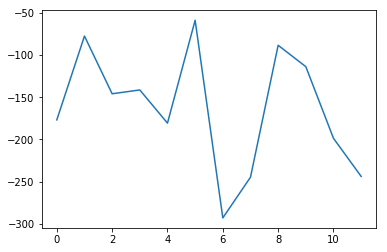

In [7]:
plt.plot(gas_year_month.transaction_amount[gas_year_month.year==2016])

In [8]:
prev_years_gas = df[(df.transaction_type_desc == 'Gas')]
prev_years_gas['transaction_amount'] = prev_years_gas['transaction_amount'].abs()

## Gas expenses by month with multiple lines to show each year.

## Surprisingly, with this being random data, there appears to be a trend of low gas expenses in February, that trends up into April and then back down to June. July and August show a shift back up with another downward trend in September.

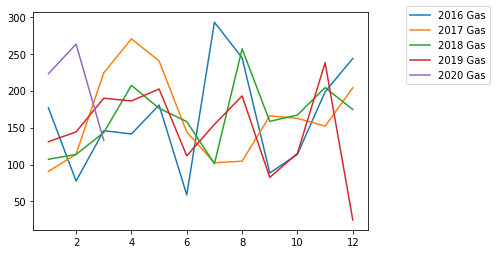

In [9]:
ax = plt.subplot(111)
for year in list(prev_years_gas.year.unique()):
    plt.plot(prev_years_gas[['month','transaction_amount']][prev_years_gas.year == year].groupby('month').sum(), label=str(year) + ' Gas')
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [10]:
# December 2019 is really low, let's check the actual dollar amount.  Wow, only $25 for gas in a month!
prev_years_gas[['transaction_amount']][(prev_years_gas.year==2019) & (prev_years_gas.month==12)].sum()

transaction_amount    25.0
dtype: float64

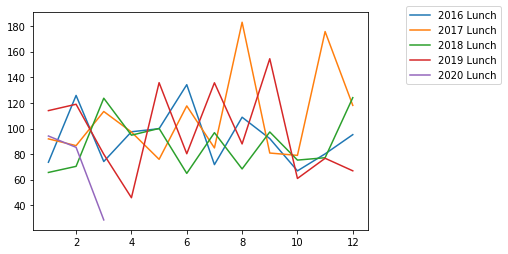

In [11]:
prev_years_lunch = df[(df.transaction_type_desc == 'Lunch')]
prev_years_lunch['transaction_amount'] = prev_years_lunch['transaction_amount'].abs()
ax = plt.subplot(111)
for year in list(prev_years_lunch.year.unique()):
    plt.plot(prev_years_lunch[['month','transaction_amount']][prev_years_lunch.year == year].groupby('month').sum(), label=str(year) + ' Lunch')
ax.legend(bbox_to_anchor=(1.1, 1.05))

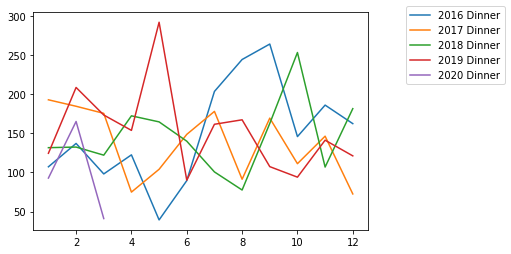

In [12]:
prev_years_dinner = df[(df.transaction_type_desc == 'Dinner')]
prev_years_dinner['transaction_amount'] = prev_years_dinner['transaction_amount'].abs()
ax = plt.subplot(111)
for year in list(prev_years_dinner.year.unique()):
    plt.plot(prev_years_dinner[['month','transaction_amount']][prev_years_dinner.year == year].groupby('month').sum(), label=str(year) + ' Dinner')
ax.legend(bbox_to_anchor=(1.1, 1.05))

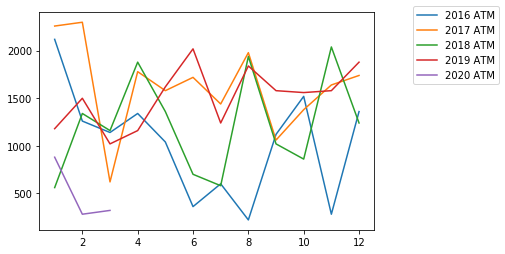

In [13]:
prev_years_atm = df[(df.transaction_type_desc == 'ATM Withdrawal')]
prev_years_atm['transaction_amount'] = prev_years_atm['transaction_amount'].abs()
ax = plt.subplot(111)
for year in list(prev_years_atm.year.unique()):
    plt.plot(prev_years_atm[['month','transaction_amount']][prev_years_atm.year == year].groupby('month').sum(), label=str(year) + ' ATM')
ax.legend(bbox_to_anchor=(1.1, 1.05))

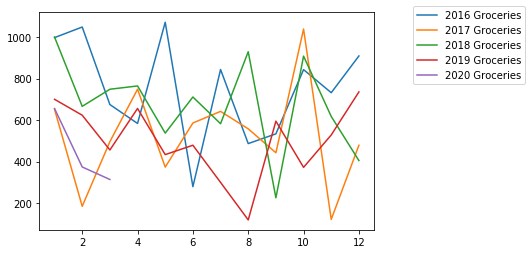

In [15]:
prev_years_groceries = df[(df.transaction_type_desc == 'Groceries')]
prev_years_groceries['transaction_amount'] = prev_years_groceries['transaction_amount'].abs()
ax = plt.subplot(111)
for year in list(prev_years_groceries.year.unique()):
    plt.plot(prev_years_groceries[['month','transaction_amount']][prev_years_groceries.year == year].groupby('month').sum(), label=str(year) + ' Groceries')
ax.legend(bbox_to_anchor=(1.1, 1.05))

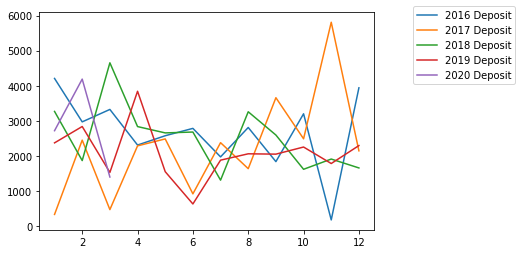

In [16]:
prev_years_deposit = df[(df.transaction_type_desc == 'Deposit')]
prev_years_deposit['transaction_amount'] = prev_years_deposit['transaction_amount'].abs()
ax = plt.subplot(111)
for year in list(prev_years_deposit.year.unique()):
    plt.plot(prev_years_deposit[['month','transaction_amount']][prev_years_deposit.year == year].groupby('month').sum(), label=str(year) + ' Deposit')
ax.legend(bbox_to_anchor=(1.1, 1.05))

## Next, we'll take a look at days where we have multiple transaction of the same type.  Looking at the first few rows, there were 2 dinners on the same day.  How many more days has our individual had multiple meals, etc.?